# 2 Player FPSB Auction with symmetric valuation distributions

## Imports

In [1]:
import os
import sys
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

In [2]:
import torch
import torch.nn as nn
import torch.nn.utils as ut
from torch.optim.optimizer import Optimizer, required

In [3]:
from bnelearn.strategy import NeuralNetStrategy, TruthfulStrategy
from bnelearn.bidder import Bidder
from bnelearn.mechanism import FirstPriceSealedBidAuction, VickreyAuction
from bnelearn.optimizer import ES
from bnelearn.environment import AuctionEnvironment

In [4]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
#
#plt.ion()

In [5]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
print(device)

cuda


## Settings

The following cell fully defines an experiment

In [7]:
run_dir = 'fpsb_2p_symmetric_normal'
run_name = 'test_long_5'
logdir = os.path.join(root_path, 'notebooks', run_dir , run_name)

## Experiment setup
n_players = 2
n_items = 1

# valuation distribution
valuation_mean = 10.0
valuation_std = 5.0

def strat_to_bidder(strategy, batch_size):
    return Bidder.normal(valuation_mean, valuation_std, strategy, batch_size = batch_size, n_players=1)

## Environment settings
#training batch size
batch_size = 2**12
input_length = 1

# strategy model architecture
size_hidden_layer = 10

# optimization params
epoch = 20000
learning_rate = 1e-1
lr_decay = True
lr_decay_every = 1000
lr_decay_factor = 0.7
baseline = True
momentum = 0.7

sigma = .02 #ES noise parameter
n_perturbations = 192

# plot and log training options
plot_epoch = 500
plot_points = min(250, batch_size)
plot_xmin = int(max(0, valuation_mean - 3*valuation_std))
plot_xmax = int(valuation_mean + 3*valuation_std)

plot_ymin = 0
plot_ymax = 15

#sample_points = torch.from_numpy(np.linspace(plot_xmin, plot_xmax, plot_xmax - plot_xmin + 1)).float().view(-1, n_items).cuda()

# tensorboard writer settings

## Optimal Bid Function

According to Menezes et al. 2005., the optimal bid for symmetric valuations $v$ that are distributed with cdf $F(v)$ for $n$ players in this setting is given by

$$b^*(v) = v - \frac{\int_0^v F(x)^{n-1} dx}{F(v)^{n-1}} $$


We implement it here for calculating comparison metrics.

In [8]:
import scipy.integrate as integrate

common_dist = torch.distributions.normal.Normal(loc = valuation_mean, scale = valuation_std)

# TODO: investigate where everything is allocated. possibly move GPU vectors to CPU completely instead of shuffling around for integration?
def optimal_bid(valuation: torch.Tensor or np.ndarray or float) -> torch.Tensor:
    
    # For float and numpy --> convert to tensor
    if not isinstance(valuation, torch.Tensor):
        valuation = torch.tensor(valuation, dtype = torch.float)           
    # For float / 0d tensors --> unsqueeze to allow list comprehension below
    if valuation.dim() == 0:
        valuation.unsqueeze_(0)
    
    # shorthand notation for F^(n-1)
    Fpowered = lambda v: torch.pow(common_dist.cdf(v), n_players - 1)  
    
    # do the calculations
    numerator = torch.tensor(
            [integrate.quad(Fpowered, 0, v)[0] for v in valuation],
            device = valuation.device
        ).reshape(valuation.shape)                                 
    return valuation - numerator / Fpowered(valuation)

# Setting up the Environment

In [9]:
def log_hyperparams(writer, e):
    writer.add_scalar('hyperparams/batch_size', batch_size, e)
    writer.add_scalar('hyperparams/size_hidden_layer', size_hidden_layer, 0)
    writer.add_scalar('hyperparams/learning_rate', learning_rate, e)
    writer.add_scalar('hyperparams/momentum', momentum, e)
    writer.add_scalar('hyperparams/sigma', sigma, e)
    writer.add_scalar('hyperparams/n_perturbations', n_perturbations, e)

    
    
# predefine points for plotting optimal curve to save cpu-bound integrations
v_opt = np.linspace(plot_xmin, plot_xmax, 100) # 100 points more than enough
b_opt = optimal_bid(v_opt).numpy()

def plot_bid_function(fig, v,b, writer=None, e=None, plot_points=100):
    
    # subsample points and plot
    v = v.detach().cpu().numpy()[:plot_points]
    b= b.detach().cpu().numpy()[:plot_points]
    
    fig = plt.gcf()
    plt.cla()
    plt.xlim(plot_xmin, plot_xmax)
    plt.ylim(plot_ymin, plot_ymax)
    plt.plot(v,b, 'o', v_opt, b_opt, 'r--')
    #if is_ipython:
    #    display.clear_output(wait=True)
    display.display(plt.gcf())
    if writer:
        writer.add_figure('eval/bid_function', fig, e)  

In [10]:
model = NeuralNetStrategy(input_length,
                          size_hidden_layer = size_hidden_layer,
                          requires_grad=False
                         ).to(device)

In [11]:
mechanism = FirstPriceSealedBidAuction(cuda = True)
env = AuctionEnvironment(mechanism,
                  agents = [], #dynamically built
                  max_env_size = 1, #
                  batch_size = batch_size,
                  n_players =n_players,
                  strategy_to_bidder_closure = strat_to_bidder
                 )
optimizer = ES(model=model, environment = env,
               lr = learning_rate, momentum=momentum,
               sigma=sigma, n_perturbations=n_perturbations,
               baseline=baseline)

## Training

/opt/anaconda/anaconda3/envs/bnelearn/lib/python3.7/site-packages/ipykernel_launcher.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Epoch 0: 	total share: 0.221693, diff: -4.437573, 	utility: 8.886642


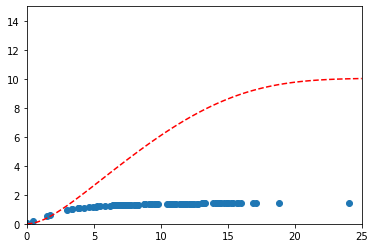

Epoch 500: 	total share: 1.375037, diff: 2.140932, 	utility: 2.194138


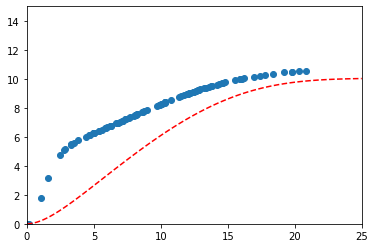

Epoch 1000: 	total share: 1.215932, diff: 1.234992, 	utility: 3.009081


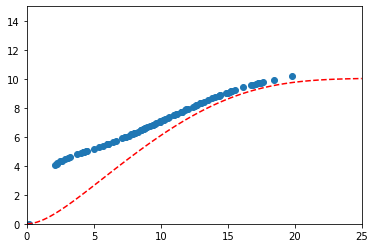

Epoch 1500: 	total share: 1.320542, diff: 1.831954, 	utility: 2.446676


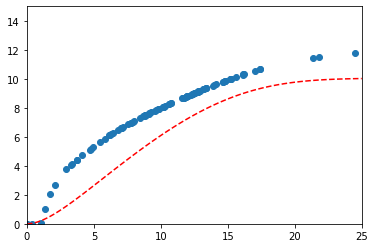

Epoch 2000: 	total share: 1.451301, diff: 2.563652, 	utility: 1.823911


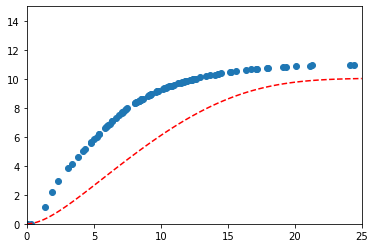

Epoch 2500: 	total share: 1.183294, diff: 1.045409, 	utility: 3.306986


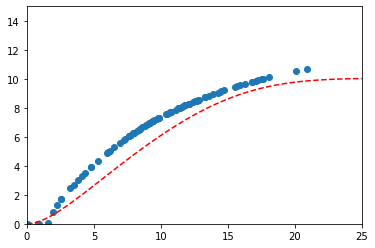

Epoch 3000: 	total share: 1.042953, diff: 0.242232, 	utility: 3.942760


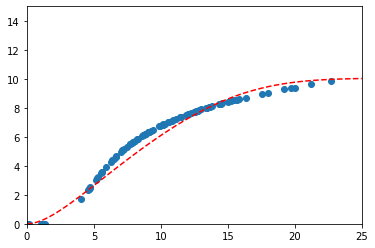

Epoch 3500: 	total share: 0.890030, diff: -0.632013, 	utility: 4.831974


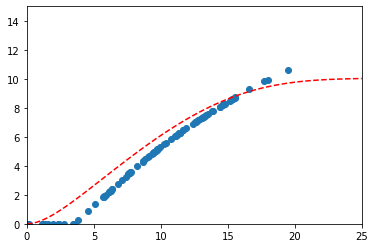

Epoch 4000: 	total share: 0.917976, diff: -0.475010, 	utility: 4.660277


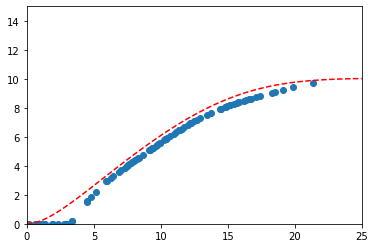

Epoch 4500: 	total share: 0.901521, diff: -0.571148, 	utility: 4.700535


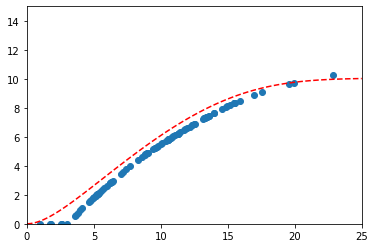

Epoch 5000: 	total share: 1.102431, diff: 0.591350, 	utility: 3.656982


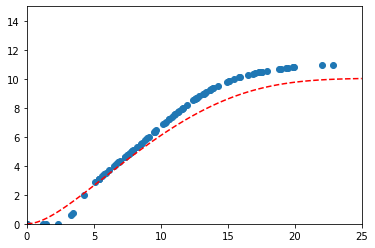

Epoch 5500: 	total share: 1.164637, diff: 0.935627, 	utility: 3.274421


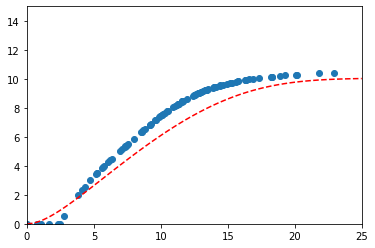

Epoch 6000: 	total share: 1.110818, diff: 0.626294, 	utility: 3.672502


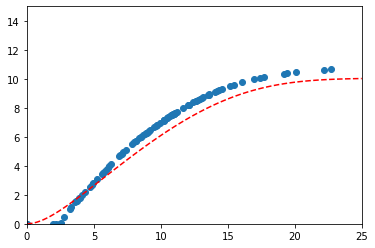

Epoch 6500: 	total share: 0.988998, diff: -0.062921, 	utility: 4.328872


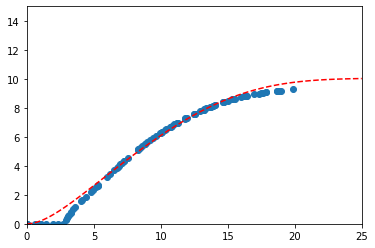

Epoch 7000: 	total share: 1.065371, diff: 0.376197, 	utility: 3.826799


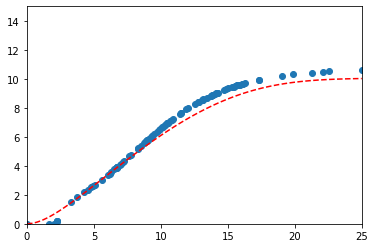

Epoch 7500: 	total share: 1.062807, diff: 0.360012, 	utility: 3.921160


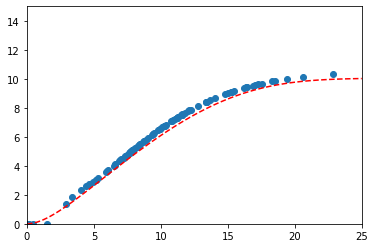

Epoch 8000: 	total share: 1.147877, diff: 0.843018, 	utility: 3.420484


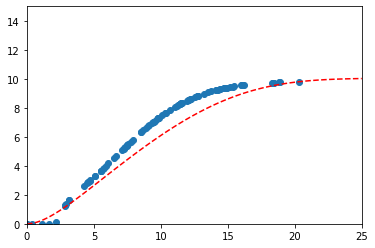

Epoch 8500: 	total share: 0.941265, diff: -0.336369, 	utility: 4.671272


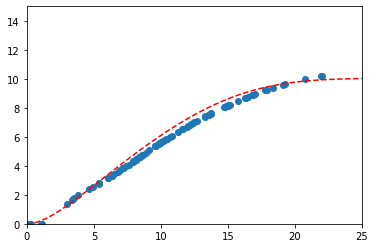

Epoch 9000: 	total share: 1.076072, diff: 0.433698, 	utility: 3.814844


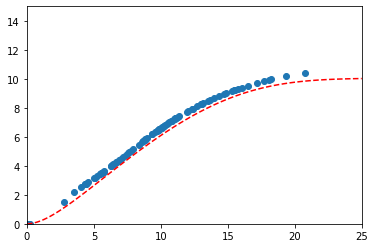

Epoch 9500: 	total share: 1.051421, diff: 0.290965, 	utility: 4.077212


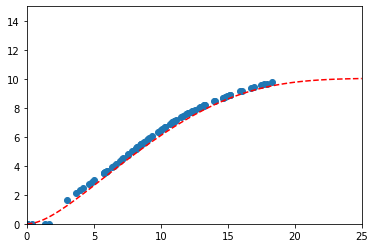

Epoch 10000: 	total share: 1.042858, diff: 0.246277, 	utility: 4.032091


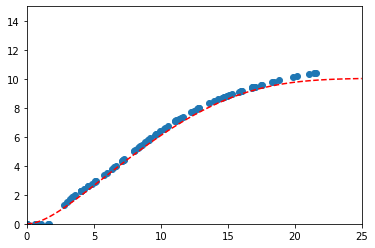

Epoch 10500: 	total share: 1.082121, diff: 0.472481, 	utility: 3.855955


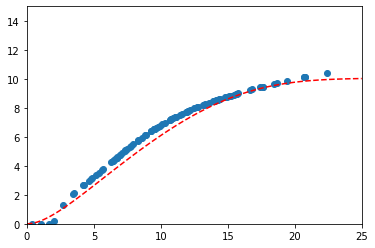

Epoch 11000: 	total share: 1.045064, diff: 0.256151, 	utility: 4.053719


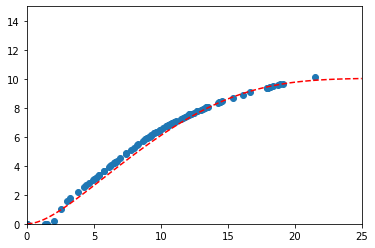

Epoch 11500: 	total share: 1.057482, diff: 0.326469, 	utility: 3.877242


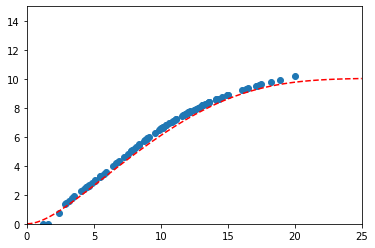

Epoch 12000: 	total share: 0.951705, diff: -0.279742, 	utility: 4.606060


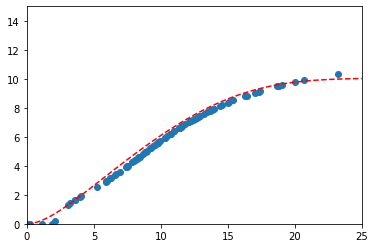

Epoch 12500: 	total share: 0.984383, diff: -0.089520, 	utility: 4.384691


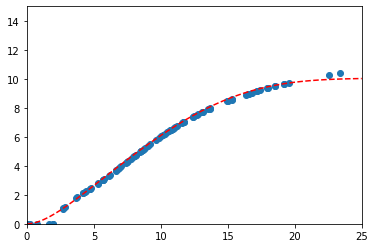

Epoch 13000: 	total share: 1.025703, diff: 0.147393, 	utility: 4.139765


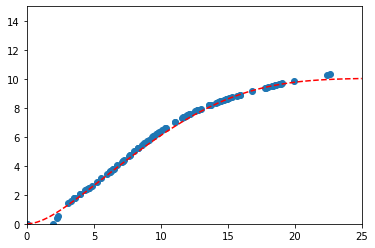

Epoch 13500: 	total share: 1.015321, diff: 0.088470, 	utility: 4.214416


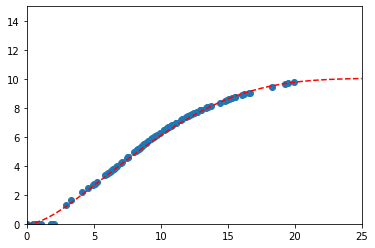

Epoch 14000: 	total share: 1.005206, diff: 0.029946, 	utility: 4.270334


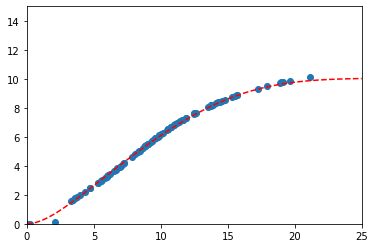

Epoch 14500: 	total share: 0.977111, diff: -0.131278, 	utility: 4.436619


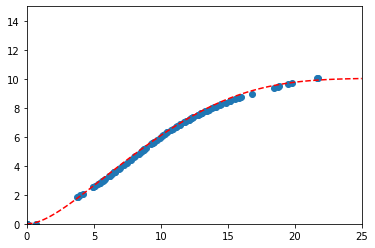

Epoch 15000: 	total share: 0.993071, diff: -0.039453, 	utility: 4.360200


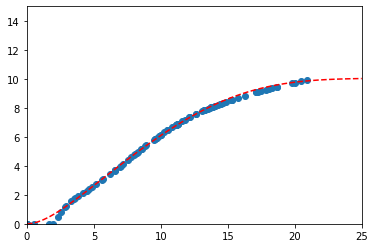

Epoch 15500: 	total share: 1.017698, diff: 0.101365, 	utility: 4.172683


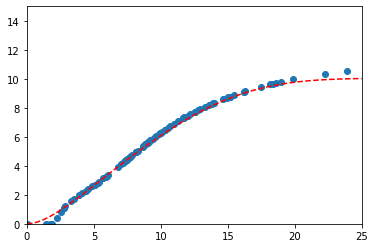

Epoch 16000: 	total share: 1.004930, diff: 0.028439, 	utility: 4.209901


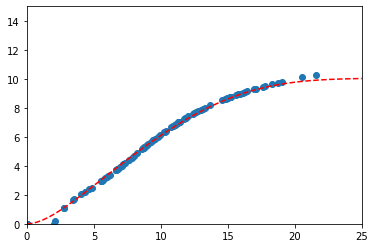

Epoch 16500: 	total share: 1.001517, diff: 0.008645, 	utility: 4.319989


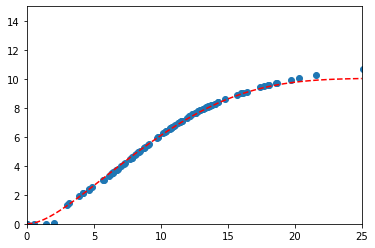

Epoch 17000: 	total share: 0.984509, diff: -0.089702, 	utility: 4.352054


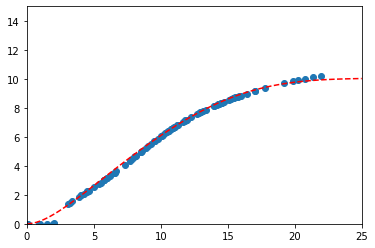

Epoch 17500: 	total share: 0.982915, diff: -0.097776, 	utility: 4.296316


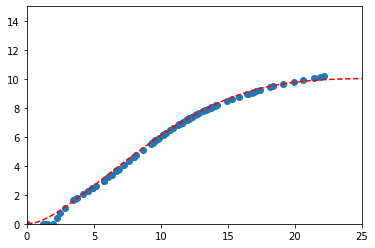

Epoch 18000: 	total share: 0.990165, diff: -0.056977, 	utility: 4.327299


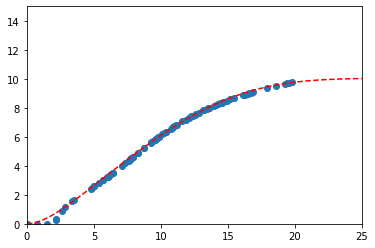

Epoch 18500: 	total share: 0.988489, diff: -0.065821, 	utility: 4.259714


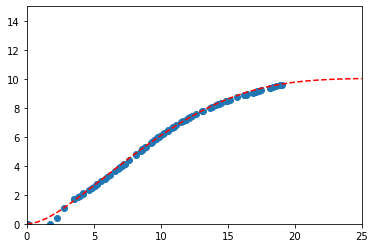

Epoch 19000: 	total share: 0.989585, diff: -0.060170, 	utility: 4.308693


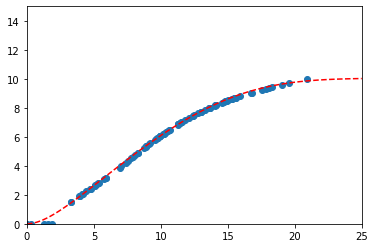

Epoch 19500: 	total share: 0.991286, diff: -0.050182, 	utility: 4.267534


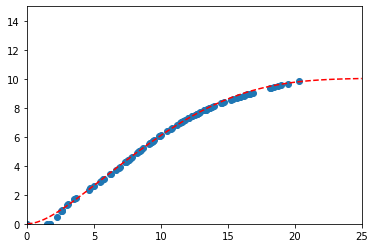

Epoch 20000: 	total share: 0.992654, diff: -0.042824, 	utility: 4.270149


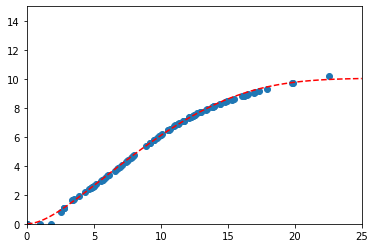

In [12]:
with SummaryWriter(logdir, flush_secs=120) as writer:
    torch.cuda.empty_cache()
    log_hyperparams(writer, 0)
    fig = plt.figure()
    for e in range(epoch+1):
        # lr decay?
        if lr_decay and e % lr_decay_every == 0 and e > 0:
            learning_rate = learning_rate * lr_decay_factor
            log_hyperparams(writer, e)
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

        # always: do optimizer step
        utility = -optimizer.step()
        writer.add_scalar('eval/utility', utility, e)

        if e % plot_epoch == 0:
            # plot current function output
            bidder = strat_to_bidder(model, batch_size)
            bidder.draw_valuations_()
            v = bidder.valuations
            b = bidder.get_action()
            
            opt_bid = optimal_bid(v)
            
            share = b.mean()/opt_bid.mean()
            diff = (b-opt_bid).mean()
            writer.add_scalar('eval/share', share, e)
            writer.add_scalar('eval/diff', diff, e) 


            print("Epoch {}: \ttotal share: {:2f}, diff: {:2f}, \tutility: {:2f}".format(e, share, diff, utility))
            plot_bid_function(fig, v,b,writer,e)        

            writer.add_graph(model, bidder.valuations)